# Training and evaluation notebook

In [2]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [3]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


## 2. Add indices

In [4]:
merged_df['NDVI'] = (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'])

# EVI is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions
# It's calculated using the Red (B4), Near-Infrared (B8 or B5), and Blue (B2) bands.
merged_df['EVI'] = 2.5 * (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + 6 * merged_df['B4'] - 7.5 * merged_df['B2'] + 1)

# NDWI is used to monitor changes in water content of leaves
# It is typically calculated using the Near-Infrared (B8 or B5) and Short-Wave Infrared (B11 or B6) bands.
merged_df['NDWI'] = (merged_df['B8'] - merged_df['B11']) / (merged_df['B8'] + merged_df['B11'])

# SAVI is a modification of NDVI to correct for the influence of soil brightness
# The standard value of L in the SAVI formula is 0.5.
L = 0.5  # soil brightness correction factor
merged_df['SAVI'] = ((merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'] + L)) * (1 + L)

# GNDVI is used to estimate vegetation health
# It's calculated using the Near-Infrared (B8 or B5) and Green (B3) bands.
merged_df['GNDVI'] = (merged_df['B8'] - merged_df['B3']) / (merged_df['B8'] + merged_df['B3'])

merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372873,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625818,0.443384,0.076328,0.432730,0.637691
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


## 3. EDA

Distribution of classes in feature space. The plot will show the spectral signature (digital number) of different bands (S2 bands) for each class, allowing you to visualize how these signatures vary across classes.

In [4]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11',
       'B12']

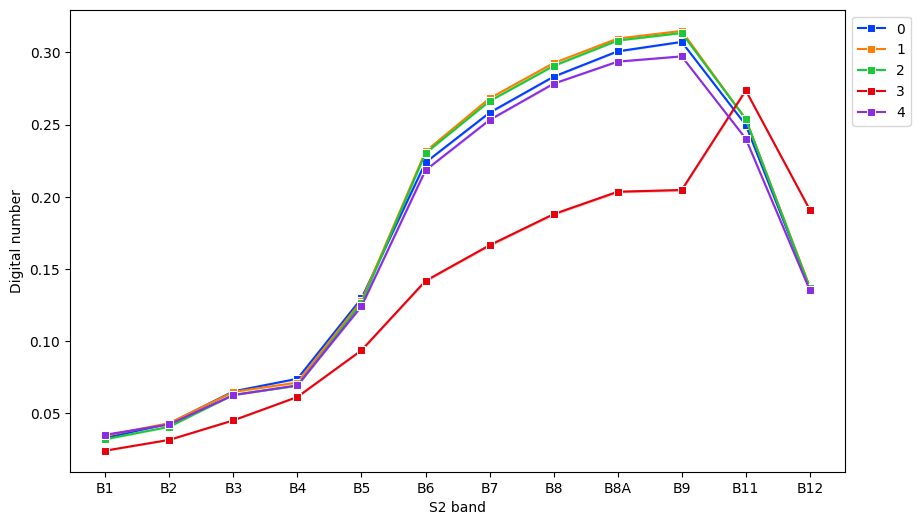

In [6]:

# Flatten the data
data_flat = pd.melt(merged_df.drop(columns =["sample_location_id", 'NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI'], axis=1), id_vars="class")
data_flat.columns = ["class", "S2 band", "Digital number"]

# Plot spectra using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.lineplot(data=data_flat, x="S2 band", y="Digital number", hue="class", marker="s", palette="bright")

# Adjust legend position
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

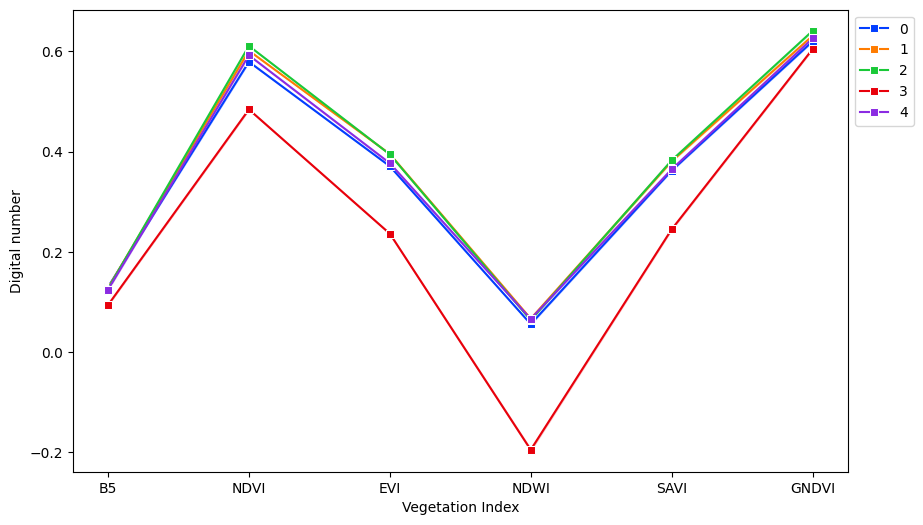

In [8]:
# Flatten the data
data_flat_1 = pd.melt(merged_df.drop(columns =["sample_location_id", 'B1', 'B2', 'B3', 'B4', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'], axis=1), id_vars="class")
data_flat_1.columns = ["class", "Vegetation Index", "Digital number"]

# Plot spectra using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.lineplot(data=data_flat_1, x="Vegetation Index", y="Digital number", hue="class", marker="s", palette="bright")

# Adjust legend position
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

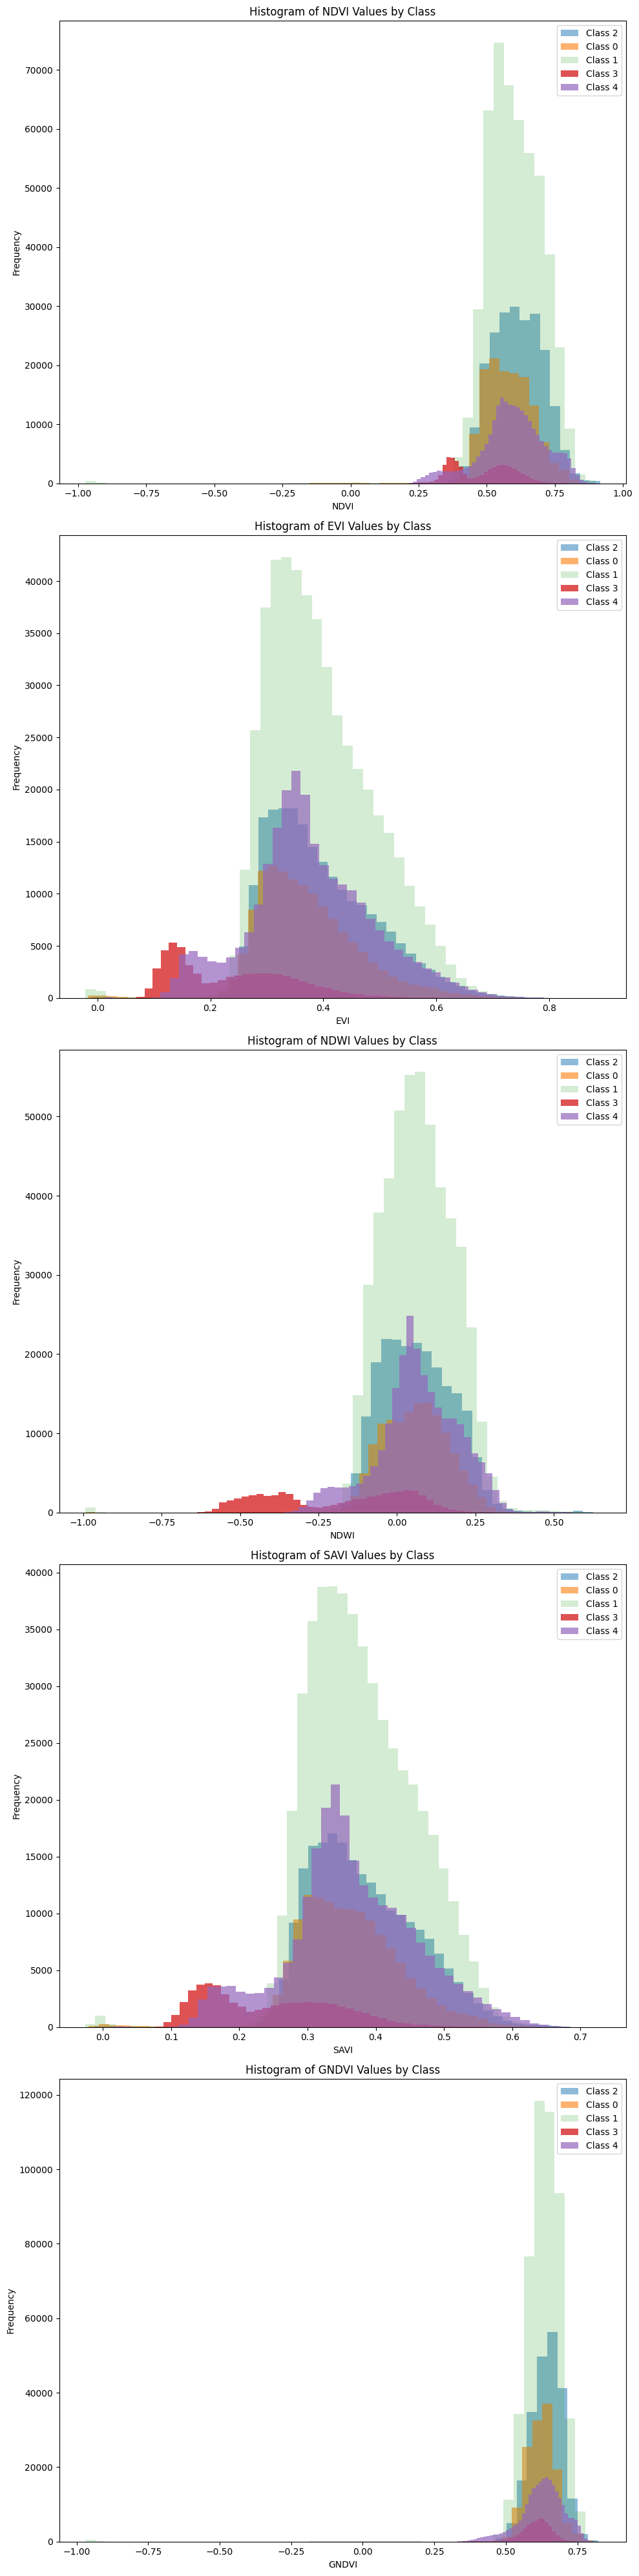

In [81]:
# Assuming merged_df is your DataFrame and is already loaded

# List of vegetation indices to plot
vegetation_indices = ['NDVI', 'EVI', 'NDWI', 'SAVI', 'GNDVI']


# Custom alpha values for each class - example
alpha_values = {
    0: 0.6,  # Class 0 with alpha 0.3
    1: 0.2,  # Class 1 with alpha 0.5
    2: 0.5,  # Class 2 with alpha 0.7
    3: 0.8,  # Class 3 with alpha 0.9
    4: 0.7   # Class 4 with alpha 1.0 (fully opaque)
}

# Set up the plot
num_plots = len(vegetation_indices)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 8*num_plots))

for i, vi in enumerate(vegetation_indices):
    for class_id in merged_df['classes'].unique():
        # Filter data for the current class
        class_data = merged_df[merged_df['classes'] == class_id]
        
        # Determine alpha for the current class, default to 0.5 if class_id not in alpha_values
        alpha = alpha_values.get(class_id, 0.5)
        
        # Plot histogram with class-specific alpha
        axes[i].hist(class_data[vi], bins=50, alpha=alpha, label=f'Class {class_id}')
    
    axes[i].set_title(f'Histogram of {vi} Values by Class')
    axes[i].set_xlabel(vi)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()
